<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 2 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook__

<b>Enter you student details below</b>

- <b>Student Name:</b> Alexander Li
- <b>Student ID:</b> 30630711

<div class="alert alert-block alert-danger">

# Table of Contents
    
* [Libraries](#Libraries)
    
* [Task 2.1: Create dataloader for Face Data and Visualise a few samples](#t2_1)
    
* [Task 2.2: Design your network architecture for AE](#t2_2)
    
* [Task 2.3: Train your model and evaluate the DAE results](#t2_3)
    
* [Task 2.4: Visualise reconstructed images along with the clean data](#t2_4)
    
* [Task 2.5: Compute Peak Signal To Noise Ratio (PSNR)](#t2_5)
    
* [Task 2.6: Discussion Question](#t2_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [1]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [2]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device

Global seed set to 4179


<div class="alert alert-block alert-info">

# DAE: Denoising Autoencoder
    
## What you should do in this task!

In this task you will be training an autoencoder to denoise images using Pytorch and PyTorch Lightning functionalities we have previously encountered!

Use Pytorch and the Pytorch Lightning module class to create an autoencoder architecture in order to denoise (noisy) face data, and train your model using ADAM. The image below shows a denoising autoencoder applied to the MNIST dataset

<img src="figures/denoising_ae_image.png" width="700" align="center">
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders.
 2. Visualise a training sample using the dataloader.
 3. Design the neural network model.
 4. Perform training of the model and evaluation.
 5. Visualise experimental results.
    


<div class="alert alert-block alert-info">

### Task 2.1: Create dataloader for Face Data and Visualise a few samples <a class="anchor" id="t2_1"></a>

Use the **random_split** function to divide the training dataset into Train, Validation and Test. You must use 20% of the training data as Validation data during training and keep 20% as Testing data.

In [12]:
# Create your class for the face data 
# The face data can be reshaped into the shape of (N, 64, 64) where N is the size of the dataset
# It is always recommended to print the shape of the numpy array before reshaping, just to ensure the dimensions are correct
from torch.utils.data import Dataset, DataLoader
class FaceData(Dataset):
    def __init__(self, transform=None):
        self.images = np.load(PATH_DATASETS + "/face_data.npy")

        # Define your self.images and self.transform
        #self.images = self.images.reshape(-1, 64, 64)
        self.transform = transform
        # Are there labels in this dataset? Think about what the task is and why there may (or may not be) labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx.to_list()

        sample = self.images[idx, :].reshape((64,64))
    
        # If there is a transform, apply it here to your sample
        if self.transform:
            sample = self.transform(sample)
        return sample

In [15]:
# data transform without data augmentation
data_transform = transforms.Compose([
    transforms.ToPILImage(), # PIL [Python Imaging Library] is a Python package to read images. This allows you to use the resize transform.
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

# Load in dataloader
train_set = FaceData(transform=data_transform)

# Split the train set into training, validation and test
train_set, val_set = random_split(train_set, [int(len(train_set)*0.6), len(train_set) - int(len(train_set)*0.6)])
val_set, test_set = random_split(val_set, [int(len(val_set)*0.5), len(val_set) - int(len(val_set)*0.5)])

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)



1800


Let's add some noise to the data samples!

Text(0.5, 1.0, 'noisy dataset')

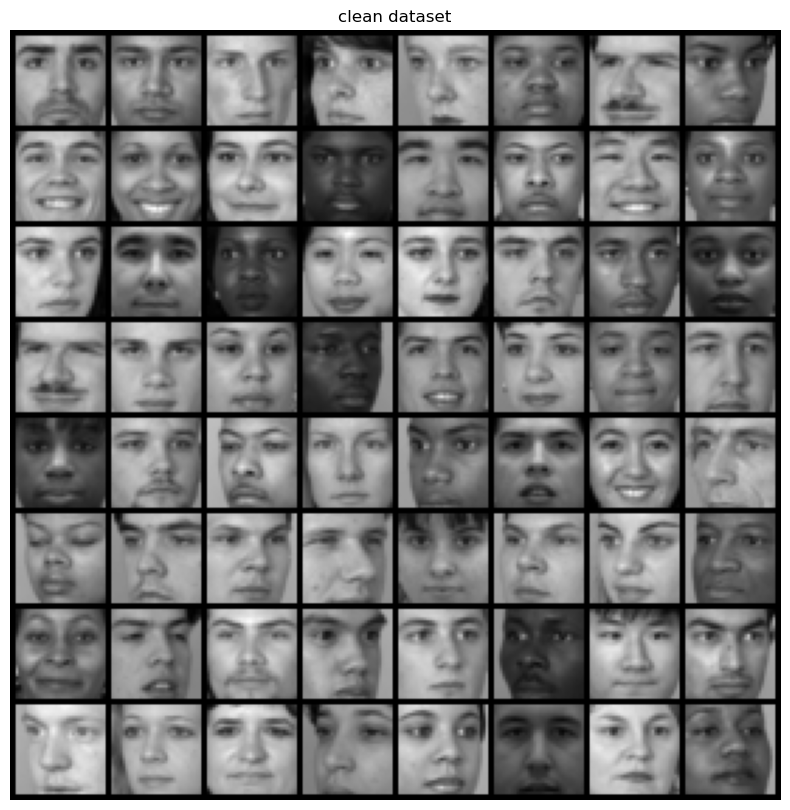

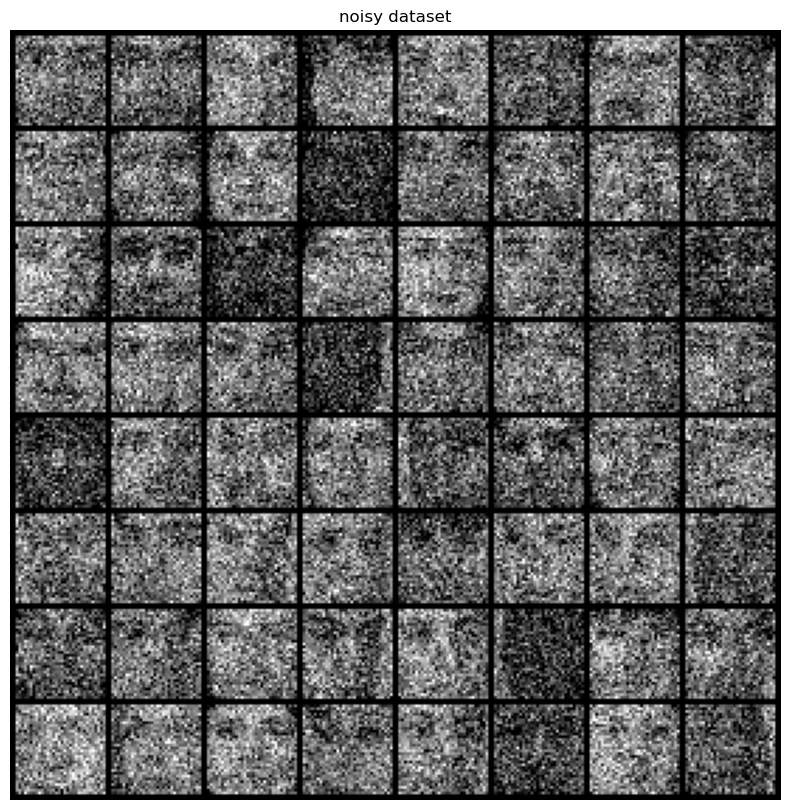

In [28]:
# Create noisy samples by noise_percentage * torch.randn_like(data0). 
# You can use torch.randn_like(data) * noise_percentage to generate noise based around the data's distribution
# These will just be temporary noisy images. You will add in the noise during the training_step of your Simple_AE class later on.

data = next(iter(train_loader))

# Create noisy data
noise_percentage = 0.2
noisy_data = data + torch.randn_like(data) * noise_percentage
noisy_data = torch.clip(noisy_data, min=0, max=1) # Clip the data between 0 and 1. Look at the documentation for torch.clip()

# visualize clean dataset using torchvision grid
plt.figure(figsize = (20,10))
plt.axis('off')
out = torchvision.utils.make_grid(data, nrow=8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("clean dataset")

# visualize noisy dataset using torchvision grid
plt.figure(figsize = (20,10))
plt.axis('off')
out = torchvision.utils.make_grid(noisy_data, nrow=8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("noisy dataset")

<div class="alert alert-block alert-info">
    
### Task 2.2: Design your network architecture for AE <a class="anchor" id="t2_2"></a>

In this task, you will create the encoder and decoder modules that you will use within your "Simple_AE" class (which will be your DAE).

The encoder will just consist of one layer with an activation function. BatchNorm1d will also be added to the encoder to speed up convergence. The decoder will also be one layer with an activation function. You do not need to put a BatchNorm1d here.

The rest of the hyperparameters can be found within the PDF.

_Note: We have provided additional optional material in the weekly lectures for batch normalization if you wish to learn more about it. This is a useful technique in speeding up training. To use BatchNorm1d, you simply have to put in the previous layer's number of input features as the input parameter. See the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more information._

In [56]:
# Define your encoder class
# You will use one linear layer in the encoder class and pass it through BatchNorm1d() then LeakyReLU

class Encoder(nn.Module):    
    def __init__(self):
        super().__init__()
        
        # Encoder section

        # Define linear layer
        
        self.encoder = nn.Sequential(
            # Add Linear Layer
            nn.Linear(32*32, 128),
            # Add BatchNorm1d() as the next one in the sequence. 
            nn.BatchNorm1d(128),
            # Then add LeakyReLU. Note BatchNorm1d takes an input argument.
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        # Forward pass of your encoder
        x = x.reshape(x.shape[0], -1)
        return self.encoder(x)
    
# Define your decoder class
# You will use one linear layer in the encoder class and pass it through LeakyReLU only

class Decoder(nn.Module):   
    def __init__(self):
        super().__init__()
        
        # Add Linear Layer

        # Decoder section
        self.decoder = nn.Sequential(
            # Add Linear Layer
            nn.Linear(128, 32*32),
            # Add LeakyReLU.
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        # Forward pass through your decoder        
        # Pass the output of your decoder into a sigmoid function
        # Ensure you reshape to B x C x H x W before returning the values
        x = self.decoder(x)
        #x = nn.Sigmoid()(x)
        x = x.reshape(-1, 1, 32, 32)
        
        return x

Create your autoencoder class '_Simple_AE_' using LightningModule and call the Encoder and Decoder Blocks you have defined above.

In [57]:
#Let's create a simple DAE based on MLP networks
class Simple_AE(pl.LightningModule):
    
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        
        self.learning_rate = learning_rate  # Use learning rate provided
        self.criterion = nn.MSELoss()  # Define your loss
        
        self.encoder = Encoder()  # Initialise your encoder 
        self.decoder = Decoder()  # Initialise your decoder
        
    def forward(self, x):
        # Forward pass through encoder and decoder
        # Is the result the same shape as your original image? Worth to double check!
        return self.decoder(self.encoder(x))
    
    def training_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x = batch  # Retrieve image from batch
        noise_percentage = 0.2
        noisy_data = x + torch.randn_like(x) * noise_percentage # Add in noise to your data here
        noisy_data = torch.clip(noisy_data, min=0, max=1) # Clip your data between 0 and 1. You can use torch.clip()
        
        z = self.encoder(noisy_data)  # Remember, this is where we are training. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        x_hat = self.decoder(z) 

        loss = self.criterion(x_hat, x) # Think about what your loss should be comparing against. There are 3 possibilities: original "x", predicted "x", and noisy "x". Which two are correct to predict?
                                        # If your model is not converging to a non-noisy output, this loss criterion might be why! (perhaps comparing two wrong values)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss # Don't forget to return loss so that the gradients can be updated
    
    def validation_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x = batch  # Retrieve image from batch
        noise_percentage = 0.2
        noisy_data = x + torch.randn_like(x) * noise_percentage # Add in noise to your data here
        noisy_data = torch.clip(noisy_data, min=0, max=1) # Clip your data between 0 and 1. You can use torch.clip()
        
        z = self.encoder(noisy_data)  # Remember, this is where we are validating. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        x_hat = self.decoder(z) 

        loss = self.criterion(x_hat, x)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        
    def test_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x = batch  # Retrieve image from batch
        noise_percentage = 0.2
        noisy_data = x + torch.randn_like(x) * noise_percentage # Add in noise to your data here
        noisy_data = torch.clip(noisy_data, min=0, max=1) # Clip your data between 0 and 1. You can use torch.clip()
        
        z = self.encoder(noisy_data)  # Remember, this is where we are testing. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        x_hat = self.decoder(z) 

        loss = self.criterion(x_hat, x)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        
    
    def predict_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x = batch
        noise_percentage = 0.2
        noisy_data = x + torch.randn_like(x) * noise_percentage # Add in noise to your data here
        noisy_data = torch.clip(noisy_data, min=0, max=1) # Clip your data between 0 and 1. You can use torch.clip()
        # You need to return predicted "x", noisy "x", and original x. That way you can compare the results with what is expected  ! 
        z = self.encoder(noisy_data)
        x_hat = self.decoder(z)

        return x_hat, noisy_data, x  

    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    #####################
    # DATA RELATED HOOKS
    #####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
### Task 2.3: Train your model and evaluate the DAE results <a class="anchor" id="t2_3"></a>

In [58]:
# Initialize the model
model_ae = Simple_AE()

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_task_2/",
        save_top_k=1,        # save the best model
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=10, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    #devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=50,
    callbacks=[progress_bar_task, checkpoint_callback],
    logger=CSVLogger(save_dir="logs_task_2/"),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [59]:
# Train the Simple AE model
trainer_task.fit(model_ae)


c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\li420\home\Uni\2023_S2\ECE4179\assignment\checkpoints_task_2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ criterion │ MSELoss │      0 │
│ 1 │ encoder   │ Encoder │  131 K │
│ 2 │ decoder   │ Decoder │  132 K │
└───┴───────────┴─────────┴────────┘

Trainable params: 263 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 263 K                                                                                                
Total estimated model params size (MB): 1

Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
38: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4
38: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in
the `DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: 
PossibleUserWarning: The number of training batches (17) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.
  rank_zero_warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


In [60]:
# Test the model and report test accuracy and test loss
trainer_task.test(model_ae)


Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.003103419439867139    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.003103419439867139}]

Visiualise your experimental results. First, take a look at the accuracy for both training and validation. 

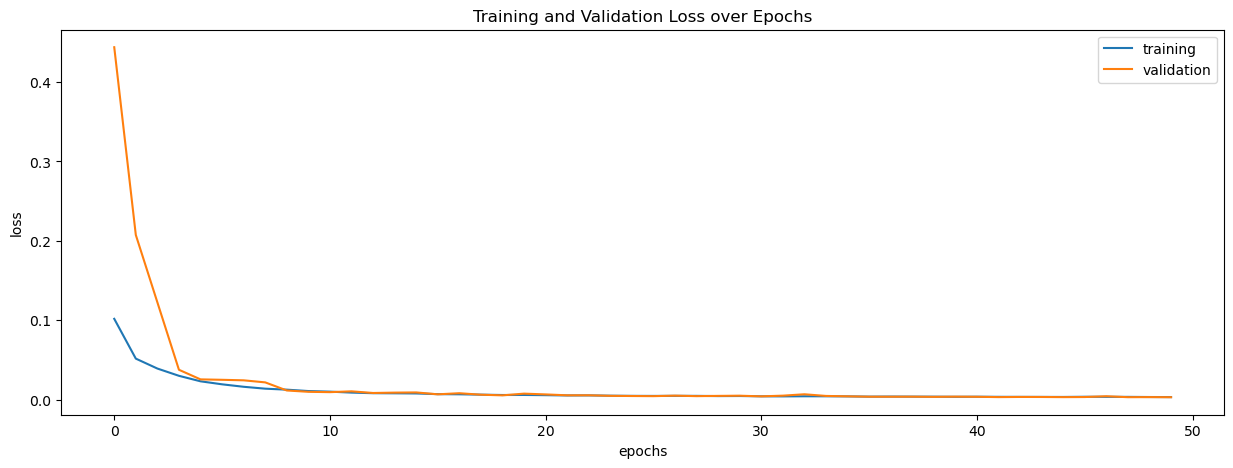

In [61]:
# Plot both training and validation losses

# read logs for task 3
task2_metrics = pd.read_csv(trainer_task.logger.log_dir+"/metrics.csv")
# other steps you think necessary
task2_metrics.set_index("epoch", inplace=True)
task2_metrics = task2_metrics.groupby(level=0).sum().drop("step", axis=1)
train_loss = task2_metrics["train_loss"][:-1]
val_loss = task2_metrics["val_loss"][:-1]

# plot training and validation loss

plt.figure(0, figsize=(15,5))
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
### Task 2.4: Visualise reconstructed images along with the clean data <a class="anchor" id="t2_4"></a>
    
Visualise some reconstructed images along with clean data and noisy data. You can use the predict function from your trainer. Reshape your output accordingly so that it is the same as the input image dimensions. Please plot at least 20 images, and make sure label your visualisations appropriately.

Output()

c:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


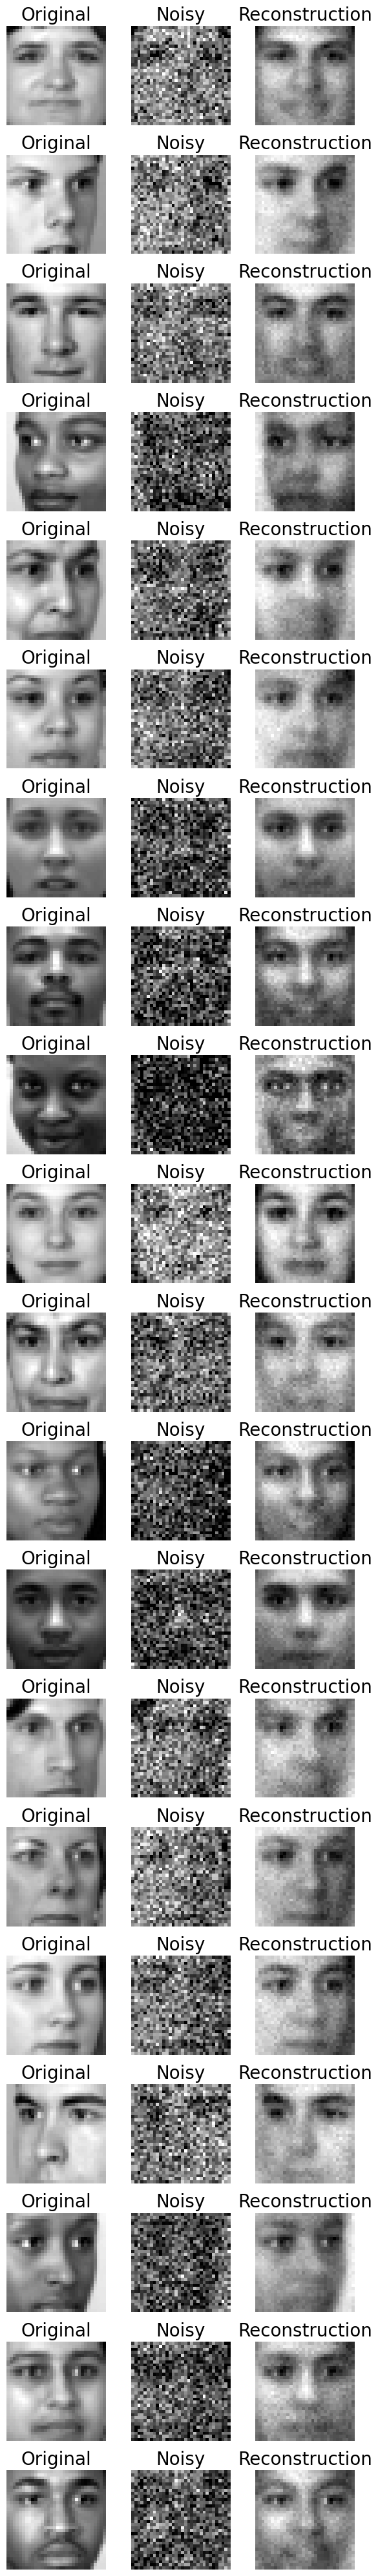

In [62]:
# Generate predictions using predict function
# Extract the predictions, noisy inputs, and clean inputs
outputs = trainer_task.predict(model_ae, test_loader)
predictions_task2, noisy_task2, inputs_task2 = outputs[0]
#print(predictions_task2.shape, noisy_task2.shape, inputs_task2.shape)

# visualize predictions along with noisy and clean input images using matplotlib
num_images = 20
image_list = inputs_task2[:num_images]
noisy_image_list = noisy_task2[:num_images]
pred_list = predictions_task2[:num_images]

num_cols = 3
num_rows = num_images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, 2*num_rows))
for i in range(num_images):
    # plot original image
    ax = axes[i, 0]
    ax.axis("off")
    ax.imshow(image_list[i, 0], cmap="gray")
    title_text = f"Original"
    ax.set_title(title_text, fontsize = 20)

    # plot noisy image
    ax = axes[i, 1]
    ax.axis("off")
    ax.imshow(noisy_image_list[i, 0], cmap="gray")
    title_text = f"Noisy"
    ax.set_title(title_text, fontsize = 20)

    # plot predicted image
    ax = axes[i, 2]
    ax.axis("off")
    ax.imshow(pred_list[i, 0], cmap="gray")
    title_text = f"Reconstruction"
    ax.set_title(title_text, fontsize = 20)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    
### Task 2.5: Peak Signal To Noise Ratio (PSNR) <a class="anchor" id="t2_5"></a>
    
Here, you need to Compute Peak Signal-to-Noise Ratio (PSNR) for test dataset. The PSNR is a commonly used metric to measure the quality of a reconstructed or denoised signal or image. The PSNR is calculated as the ratio of the peak signal power to the noise power, typically measured in decibels (dB). PSNR can be defined as </br>
</br>
    $$\mathrm{PSNR} = 10 \cdot \log_{10}\Big\lbrace\frac{{\mathrm{MAX}^2}}{{\mathrm{MSE}}}\Big\rbrace$$

Where:

`PSNR` is the Peak Signal-to-Noise Ratio in dB.

`MAX` is the maximum possible pixel value (e.g., 255 for an 8-bit image).

`MSE` is the Mean Squared Error between the original and the reconstructed (or denoised) image. It's calculated as the average of squared pixel-wise differences between the two images.

Show the PSNR values for:
- Between the noisy image and original image
- Between the reconstructed image and original image

In [63]:
from torchmetrics.image import PeakSignalNoiseRatio

psnr = PeakSignalNoiseRatio()

# Put model into eval() mode so it turns off batch norm
model_ae.eval() 

# Collect predictions and true labels
psnr_values_noisy_n_original = []
psnr_values_reconstructed_n_original = []

# Iterate over the entire test dataset and make predictions
# Make sure to use torch.no_grad below so that it does not keep track of gradients
with torch.no_grad():
    for batch in test_loader:
        # get the input and add noise
        x = batch
        noise_percentage = 0.2
        noisy_data = x + torch.randn_like(x) * noise_percentage
        noisy_data = torch.clip(noisy_data, min=0, max=1)
        # create reconstruction
        x_hat = model_ae(noisy_data)
        # calculate psnr values
        psnr_values_noisy_n_original.append(psnr(noisy_data, x))
        psnr_values_reconstructed_n_original.append(psnr(x_hat, x))
        
        
print(f"Mean PSNR value between noisy image and original image: {np.mean(psnr_values_noisy_n_original)}")
print(f"Mean PSNR value between reconstructed image and original image: {np.mean(psnr_values_reconstructed_n_original)}")

Mean PSNR value between noisy image and original image: 12.551663398742676
Mean PSNR value between reconstructed image and original image: 23.187105178833008


<div class="alert alert-block alert-success">
    
### Task 2.6: Discussion Question <a class="anchor" id="t2_6"></a>
    
### Question:

1. How does the DAE reduce the amount of noise from the input?

2. Can you think of a reason why leaky ReLU was chosen over ReLU in this case?

3. What can you say about the PSNR values? Ensure you mention whether higher or lower PSNR values are better. 

4. How could we further improve the model? 
    
### Answer

1. The DAE uses an encoder to extract the information from the noisy input; since the noise is random, it does not contain information that can be extracted, and as a result, much of the noise will not make it to the encoded vector state. The reconstruction then learns to recreate the original image, using the essence of the original image, contained in the encoded vector.

2. LeakyRelu prevents neurons from dying as soon as the weights fall into a configuration that produces a 0 output after the Relu, for some given input data. Leaky relu's always-present gradient allows those neurons to continue learning, from input data that would otherwise result in the zero gradient region of the activation function. 

3. The reconstruction has a PSNR about twice as high as the noisy image. This means the DAE has successfully removed noise. Higher PSNR is better, because it means the ratio between the signal and the noise is higher. 
 
4. Regularisation methods like reducing the number of encoder neurons, or implementing weight decay, could improve the model. These methods ensure the noise in the input do NOT get fitted / captured by the encoder network. Hence, the encoder network will focus on the meaningful information; and the decoder network will be able to reconstruct more faithfully. 